pengumpulan data

In [1]:
import pandas as pd

# Load dataset
df_fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv')
df_real = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv')

# Tambahkan label
df_fake['label'] = 0  # fake
df_real['label'] = 1  # real

# Gabungkan dataset
df = pd.concat([df_fake, df_real], ignore_index=True)
print(df['label'].value_counts())
print(df.head())


label
0    23481
1    21417
Name: count, dtype: int64
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


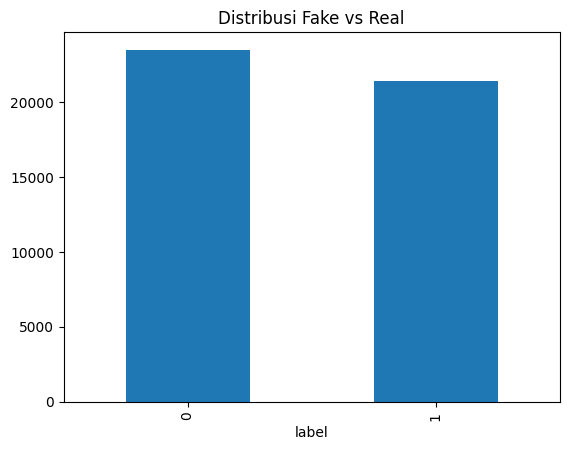

In [2]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', title='Distribusi Fake vs Real')
plt.show()

 https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

 Fitur:

title: Judul artikel
text: Isi artikel
label: Kategori berita (fake / real)

In [3]:
#pre processing
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(len(train_df), len(val_df), len(test_df))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

31428 6735 6735


In [ ]:
#seperti model transformer lain) tidak bisa menerima teks mentah.
#Harus diubah menjadi token id: representasi numerik yang dimengerti model.

In [4]:
#tokenisasi
def tokenize_fn(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

train_encodings = tokenize_fn(train_df['text'])
val_encodings = tokenize_fn(val_df['text'])
test_encodings = tokenize_fn(test_df['text'])

In [5]:
# pre trained language model RoBERTa
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#finetuning
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(
    train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_df['label'].values)
)
val_dataset = TensorDataset(
    val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_df['label'].values)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [7]:
#hyperparameter tuning
from itertools import product

learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
num_epochs_list = [2, 3]

hyperparameter_combinations = list(product(learning_rates, batch_sizes, num_epochs_list))
print("Total kombinasi:", len(hyperparameter_combinations))


Total kombinasi: 12


In [8]:
pip install transformers

In [9]:
import torch
from transformers import RobertaForSequenceClassification
from torch.optim import AdamW


In [ ]:
#looping training dan validasi
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = []

for lr, bs, epochs in hyperparameter_combinations:
    print(f"\n=== Training: lr={lr}, batch_size={bs}, epochs={epochs} ===")

    # Tokenisasi ulang (tidak wajib tapi lebih aman)
    train_encodings = tokenize_fn(train_df['text'])
    val_encodings = tokenize_fn(val_df['text'])

    train_dataset = TensorDataset(
        train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_df['label'].values)
    )
    val_dataset = TensorDataset(
        val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_df['label'].values)
    )

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs)

    # Load model baru setiap eksperimen
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"Avg train loss epoch {epoch+1}: {np.mean(epoch_losses):.4f}")

    # Validasi
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    print(f"Validation accuracy: {acc:.4f}, F1: {f1:.4f}")

    # Simpan hasil
    results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'epochs': epochs,
        'val_accuracy': acc,
        'val_f1': f1
    })



=== Training: lr=2e-05, batch_size=16, epochs=2 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/2:   1%|▏         | 29/1965 [21:26<23:22:03, 43.45s/it]

In [ ]:
#result
results_df = pd.DataFrame(results)
results_df.sort_values(by='val_f1', ascending=False, inplace=True)
print(results_df)

In [ ]:
#pre processing

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Fungsi pre-processing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Hapus tanda baca
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

# Contoh before-after
print("Before:\n", df['text'][0])
print("\nAfter:\n", df['clean_text'][0])


In [ ]:
#visualiasasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(x='epochs', y='val_f1', hue='batch_size', data=results_df)
plt.title('F1 Score by Epochs and Batch Size')
plt.show()

In [ ]:
#Pada tahap preprocessing, dilakukan penggabungan dataset Fake dan True, penambahan label (0=Fake, 1=Real), serta pembagian data menjadi train, validation, dan test set dengan proporsi 70%-15%-15%.
#Tokenisasi dilakukan menggunakan RoBERTa tokenizer dengan metode padding dan truncation hingga panjang maksimal 256 token, menghasilkan input_ids dan attention_mask yang kemudian digunakan sebagai input model.